# Train Model

### Imports

In [1]:
import sys
import os
from config import Config
sys.path.append(Config.root_path)

import importlib
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# Load Model
from Python.model.segmentation_model import deeplabv3plus
# Load Dataset & Preprocessing
from Python.data_processing.utils import get_png_paths_from_dir
from Python.data_processing.utils import load_weight_map
from Python.data_processing.utils import split_dataset_paths
from Python.data_processing.data_generator import generate_image_dataset_from_files
from Python.data_processing.data_generator import augment_dataset
# Print Model Prediction
from Python.data_processing.compare_predictions import show_predictions
# Save Model
from Python.data_processing.save_model import write_model_to_disk

print(tf.config.list_physical_devices('GPU'))

2023-04-08 19:04:46.976635: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-08 19:04:47.818906: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/lib/:/home/vidarmarsh/miniconda3/envs/tf/lib/
2023-04-08 19:04:47.819041: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/lib/:/home/vidarmarsh/miniconda3/envs/tf/lib/
2023-04-08 19:04:47.819049: W tens

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Prepare dataset

In [2]:
with open(Config.partition_path) as file:
    filename_partitions = json.load(file)
filepath_partitions = {}
for key in filename_partitions.keys():
    partition = filename_partitions.get(key).copy()
    partition[0] = [os.path.join(Config.image_path, path) for path in partition[0]]
    partition[1] = [os.path.join(Config.segmentation_path, path) for path in partition[1]]
    filepath_partitions[key] = partition
train_files = filepath_partitions.get("train")
val_files = filepath_partitions.get("validation")
test_files = filepath_partitions.get("test")
weight_map = load_weight_map(Config.weight_map_path)
train_weights = np.zeros(Config.output_channels, dtype=float)
for key in weight_map.keys():
    train_weights[int(key)] = weight_map.get(key)
val_test_weights = np.ones(Config.output_channels, dtype=np.float32)
val_test_weights[Config.background_label] = 0
train_dataset = generate_image_dataset_from_files(
    train_files[0], 
    train_files[1],
    Config.batch_size,
    tf.data.AUTOTUNE, 
    Config.shuffle_size, 
    train_weights
)
val_dataset = generate_image_dataset_from_files(
    val_files[0], 
    val_files[1],
    Config.batch_size,
    tf.data.AUTOTUNE, 
    Config.shuffle_size, 
    val_test_weights
)
test_dataset = generate_image_dataset_from_files(
    test_files[0], 
    test_files[1],
    Config.batch_size,
    tf.data.AUTOTUNE, 
    Config.shuffle_size, 
    val_test_weights
)
train_dataset = augment_dataset(train_dataset)
print(f"Datasets complete\nTrain dataset: {len(train_dataset)} batches")
print(f"Validation dataset: {len(val_dataset)} batches")
print(f"Test dataset: {len(test_dataset)} batches")

Datasets complete
Train dataset: 88 batches
Validation dataset: 19 batches
Test dataset: 19 batches


### Load Model
Load new model or continue training old model

In [3]:
# Load new model
model = deeplabv3plus(
    Config.input_shape,
    Config.batch_size,
    Config.output_channels,
    Config.channels_low,
    Config.channels_high,
    Config.middle_repeat
)

In [4]:
# # Train old model
# model_num = str(12)
# model_path = os.path.join(Config.model_dir_path, model_num, "model") 
# model = tf.keras.models.load_model(model_path, compile=False)

In [5]:
# Update any changes to Config
importlib.reload(sys.modules["config"])
from config import Config
# Compile model
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    Config.initial_learning_rate,
    decay_steps=Config.decay_steps,
    decay_rate=Config.decay_rate,
    staircase=Config.decay_discrete) # not sure about this implementation currently

trainable_count = np.sum(
    [tf.keras.backend.count_params(w) for w in model.trainable_weights]
)
print(f"Model: {model.name}\nTrainable parameters: {trainable_count}")
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate= lr_schedule),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics= ["accuracy"],
    weighted_metrics = ["accuracy"]
)

Model: model
Trainable parameters: 24705224


### Compare Image, Segmentation Mask and Prediction

2023-04-08 19:04:56.418335: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-08 19:04:56.418401: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-08 19:04:56.562272: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-08 19:04:56.562339: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

1/1 [==============================] - 4s 4s/step


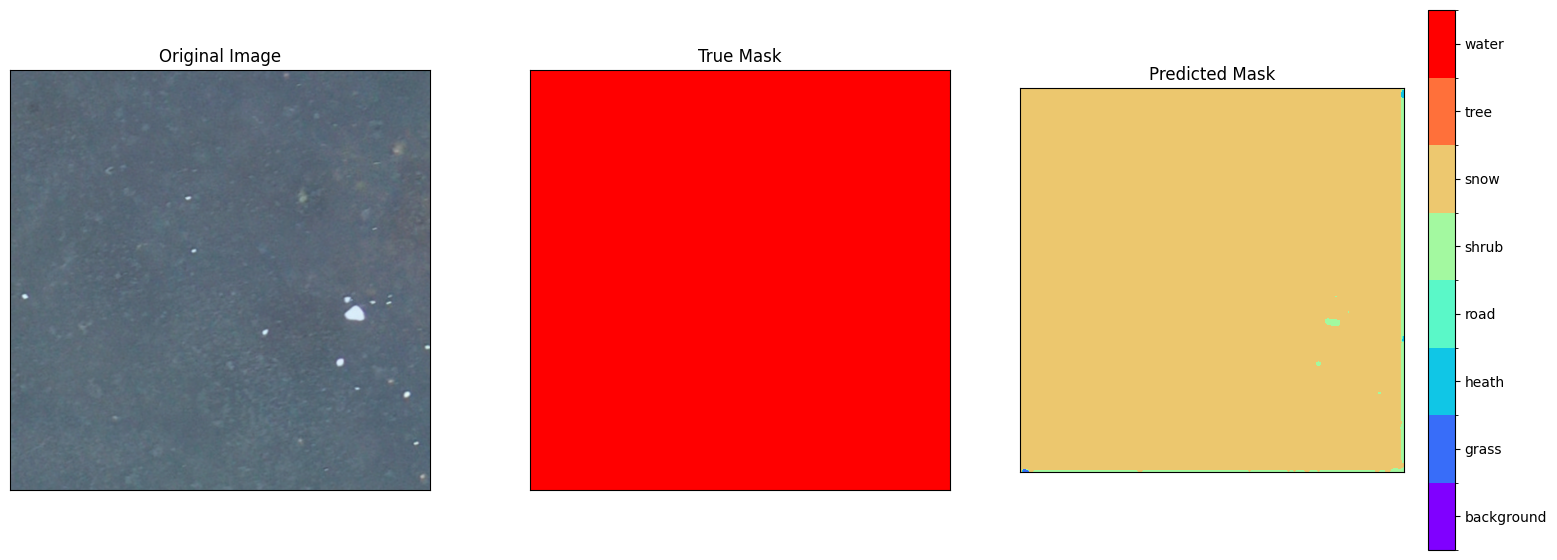

In [6]:
show_predictions(model, val_dataset)

### Model Training

Train Model

In [7]:
# Update any changes to Config
importlib.reload(sys.modules["config"])
from config import Config
# Create early exit callback
early_exit = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=8,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)
# Train model 
model_history = model.fit(
    x=train_dataset,
    epochs=Config.epochs,
    validation_data=val_dataset,
    shuffle=True,
    callbacks=early_exit
)

Epoch 1/250
88/88 [==============================] - 77s 500ms/step - loss: 1.6618 - accuracy: 0.3048 - weighted_accuracy: 0.2839 - val_loss: 1.9469 - val_accuracy: 0.0824 - val_weighted_accuracy: 0.0852
Epoch 2/250
88/88 [==============================] - 43s 491ms/step - loss: 1.3050 - accuracy: 0.4026 - weighted_accuracy: 0.4347 - val_loss: 1.7108 - val_accuracy: 0.3114 - val_weighted_accuracy: 0.3219
Epoch 3/250
 6/88 [=>............................] - ETA: 37s - loss: 1.7485 - accuracy: 0.3127 - weighted_accuracy: 0.3986

KeyboardInterrupt: 

Show Model Performance

In [ ]:
loss = model_history.history['accuracy']
val_loss = model_history.history['val_accuracy']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training accuracy')
plt.plot(model_history.epoch, val_loss, 'b', label='Validation accuracy')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 3])
plt.legend()
plt.show()

### Save Model

In [ ]:
train_names = [os.path.split(img_path)[1] for img_path in train_files[0]]
val_names = [os.path.split(img_path)[1] for img_path in val_files[0]]
test_names = [os.path.split(img_path)[1] for img_path in test_files[0]]
write_model_to_disk(
    model, model_history, filename_partitions, Config.model_dir_path, Config
)